#PREDIZIONE DELL'INDICE DI BORSA DOW JONES

Progetto preliminare all'esame di **Programmazione di Applicazioni Data Intensive**.   
Laurea in Ingegneria e Scienze Informatiche   
DISI - Università di Bologna, Cesena

Anno Accademico 2019-2020

Ameri Keivan  
Matricola: 838804   
`keivan.ameri@studio.unibo.it `

##DESCRIZIONE DEL PROBLEMA

Si vuole realizzare un modello per predirre l'indice di Borsa **Dow Jones**.    

La **Dow Jones Industrial Average**, insieme a **NASDAQ Composite** and **S&P 500**, è uno dei tre indici azionari più seguiti dello stock markets statunitense.   
Gli *indici azionari* (o Stock Indices) sintetizzano il valore di un paniere di azioni e le sue variazioni nel tempo.   
Nel nostro caso, Dow Jones è il paniere che racchiude le azioni di 30 tra le più importanti società americane.
* es. 	McDonald's Corporation, The Coca-Cola Company, 	Apple Inc, ...

    
L'obiettivo è quello di ottenere modelli, tramite i quali è possibile massimizzare il guadagno ottenibile tramite operazioni di **trading intraday**.   
L'intraday o **Day trading** consiste nel comprare e vendere prodotti finanziari all'interno dello stesso giorno. Cioè tutte le posizioni saranno chiuse entro la chiusura della borsa.  
Il Day Trading non è da confondere con lo **Scalping**, ovvero l'apertura e la chiusura di posizioni su vari prodotti finanziari, in un brevissimo arco temporale, dell'ordine di qualche minuto. Tale strategia è nota come "pip and run".   


Nello specifico si vuole predirre il valore della variabile continua che rappresenta il valore di chiusura del'indice in una determinata giornata.    
Il problema è un problema di **regressione**.   

Per raggiungere l'obiettivo, vengono usati i dati di mercato relativi a Dow Jones, resi disponibili dal sito `Yahoo! Finance`, grazie ai quali alleniamo i modelli.


##DATI DEL PROBLEMA



Installiamo **yfinance**, libreria per l'estrazione di dati dal sito `Yahoo! Finance`.

In [208]:
pip install yfinance lxml

Importiamo le librerie necessarie.

In [0]:
import yfinance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, KFold, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer
from scipy import stats


### Raccolta dati

Creiamo un oggetto Ticker. 
- Il `ticker` è un’abbreviazione che identifica le società che vengono quotate su un mercato finanziario;
- Quando una società decide di ‘diventare pubblica’, sceglie il tipo di mercato sui cui essere quotata e il ticker di identificazione.

In [0]:
djia = yfinance.Ticker("^DJI")

Tramite il metodo `history` del Ticker, scarico i tutti i dati che si riferiscono al nostro indice.
- I dati sono relativi ad un intervallo di 15 anni. Più precisamente vanno dal `2005-01-01` al `2020-01-01`
- `actions=False` esclude alcune colonne con dati non disponibili per l'indice

In [211]:
data = djia.history(start="2005-01-01", end="2020-01-01", actions=False)
data.head()

Open      High       Low     Close     Volume
Date                                                         
2005-01-03  10783.75  10867.39  10710.07  10729.43  270620000
2005-01-04  10727.81  10769.56  10605.15  10630.78  293280000
2005-01-05  10629.53  10684.43  10597.75  10597.83  263550000
2005-01-06  10593.19  10667.58  10589.33  10622.88  232850000
2005-01-07  10624.80  10653.25  10571.74  10603.96  283770000

In [212]:
data.tail()

Open      High       Low     Close     Volume
Date                                                         
2019-12-24  28572.57  28576.80  28503.21  28515.45   86150000
2019-12-26  28539.46  28624.10  28535.15  28621.39  155970000
2019-12-27  28675.34  28701.66  28608.98  28645.26  182280000
2019-12-30  28654.76  28664.69  28428.98  28462.14  181600000
2019-12-31  28414.64  28547.35  28376.49  28538.44  193340000

In [213]:
print("Numero righe: ", len(data))

Numero righe:  3775


- Ciascuna riga corrisponde ad una data, indicata nell'indice `Date`
  - le righe sono ordinate secondo un ordine crescente rispetto alla data
  - non sono presenti le righe relative a giorni di chiusura del mercato. Infatti, nonstante il periodo che stiamo considerando è di 15 anni, abbiamo i dati relativi solamente a 3775 date.
- `Open` riporta per ogni data il valore dell'indice all'apertura del mercato
- `Close` riporta per ogni data il valore dell'indice alla chiusura del mercato
- `High` riporta i massimi giornalieri
- `Low` riporta i minimi giornalieri
- `Volume` è il numero di titoli scambiati in giornata

- `Open`, `Close`, `High` e `Low` sono valori in USD (dollaro statunitense)

###Analisi esplorativa

Utilizzo il metodo `info`, per vedere il numero di istanze non nulle, il tipo delle feature e la memoria utilizzata.

In [214]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3775 entries, 2005-01-03 to 2019-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3775 non-null   float64
 1   High    3775 non-null   float64
 2   Low     3775 non-null   float64
 3   Close   3775 non-null   float64
 4   Volume  3775 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 177.0 KB



- La memoria occupata dal dataframe è pari a 117.9 KB

Utilizzo il metodo `describe`. Esso fornisce rapidamente un'insieme di statistiche sui valori di ciascuna colonna, utili ad analizzarne la distribuzione

In [215]:
data.describe()

Open         High           Low         Close        Volume
count   3775.000000   3775.00000   3775.000000   3775.000000  3.775000e+03
mean   15416.945611  15499.32520  15331.451213  15420.357253  2.153770e+08
std     5302.332457   5312.33962   5290.321712   5302.538059  1.132306e+08
min     6547.010000   6709.61000   6469.950000   6547.050000  8.410000e+06
25%    11204.390000  11276.19500  11119.990000  11205.320000  1.222700e+08
50%    13360.740000  13459.75000  13297.040000  13363.350000  2.083100e+08
75%    17988.610000  18061.39000  17917.135000  17998.060000  2.784750e+08
max    28675.340000  28701.66000  28608.980000  28645.260000  2.190810e+09

La tabella ottenuta mostra:
- `count` indica i valori non mancanti (3775)
- `mean` indica la media
  - ad esempio il valore di apertura medio durante i 10 anni presi in considerazione è 17601,997723
- `std` indica la deviazione standard
- `min` indica i valori minimo
- `max` indica i valori minimo/massimo
- `25%`/`50%`/`75%` inidcano i percentili
  - ad es. durante 25% dei giorni, si ha avuta un valore di apertura inferiore ai 12977.190 dollari

Estraggo le statistiche suddivise per anno, per quanto riguarda l'apertura e la chiusura

In [216]:
data["Open"].groupby(data["Open"].index.year).describe()

count          mean          std  ...        50%         75%       max
Date                                    ...                                 
2005  252.0  10546.036706   197.178607  ...  10548.740  10679.1850  10940.55
2006  251.0  11402.183745   491.941725  ...  11244.590  11684.1950  12510.57
2007  251.0  13174.272789   527.745322  ...  13287.910  13552.8500  14165.02
2008  253.0  11260.075020  1542.751645  ...  11659.650  12476.8100  13261.82
2009  252.0   8877.986468  1009.361726  ...   8748.900   9753.2200  10548.51
2010  252.0  10662.866071   456.053850  ...  10624.430  11021.2300  11585.38
2011  252.0  11953.786746   490.443390  ...  12047.725  12286.6400  12810.16
2012  250.0  12960.269880   322.443784  ...  12977.040  13176.5450  13597.24
2013  252.0  14995.941389   719.093941  ...  15105.315  15503.3250  16512.38
2014  252.0  16772.839802   548.903868  ...  16716.930  17067.7200  18046.58
2015  252.0  17588.974286   553.818616  ...  17741.810  17975.2350  18315.06
2016  252.0  17920.076349   936.518587  ...  17989.160  18466.4875  19968.97
2017  251.0  21740.383147  1321.640099  ...  21434.680  22418.7450  24849.63
2018  251.0  25067.933267   824.163766  ...  25036.900  25570.7200  26833.47
2019  252.0  26366.116071  1093.343063  ...  26347.440  27064.6500  28675.34

[15 rows x 8 columns]

In [217]:
data["Close"].groupby(data["Close"].index.year).describe()

count          mean          std  ...        50%         75%       max
Date                                    ...                                 
2005  252.0  10546.655556   197.113381  ...  10548.720  10683.1400  10940.55
2006  251.0  11409.779721   494.235896  ...  11247.870  11703.8450  12510.57
2007  251.0  13178.255378   525.600948  ...  13291.650  13552.7100  14164.53
2008  253.0  11244.062609  1545.442393  ...  11656.070  12466.1600  13058.20
2009  252.0   8885.654683  1014.082935  ...   8747.090   9764.9950  10548.51
2010  252.0  10668.583452   459.627670  ...  10626.545  11026.7175  11585.38
2011  252.0  11957.570000   490.405416  ...  12049.470  12287.3225  12810.54
2012  250.0  12965.313440   319.393652  ...  12980.905  13177.1700  13610.15
2013  252.0  15009.522778   715.708556  ...  15112.190  15501.9575  16576.66
2014  252.0  16777.690913   552.708219  ...  16718.280  17069.9900  18053.71
2015  252.0  17587.088294   554.686350  ...  17734.955  17977.1350  18312.39
2016  252.0  17927.107341   942.755397  ...  18003.955  18475.2900  19974.62
2017  251.0  21750.203745  1322.007852  ...  21414.340  22485.0950  24837.51
2018  251.0  25053.949960   829.172328  ...  25027.070  25566.7300  26828.39
2019  252.0  26379.543810  1079.530290  ...  26407.790  27079.6350  28645.26

[15 rows x 8 columns]

Ora estraggo i valori della colonne del nostro DataFrame

In [0]:
open_values = data["Open"]
close_values = data["Close"]
high_values = data["High"]
low_values = data["Low"]
volume_values = data["Volume"]

A seguire vengono mostrati dei grafici

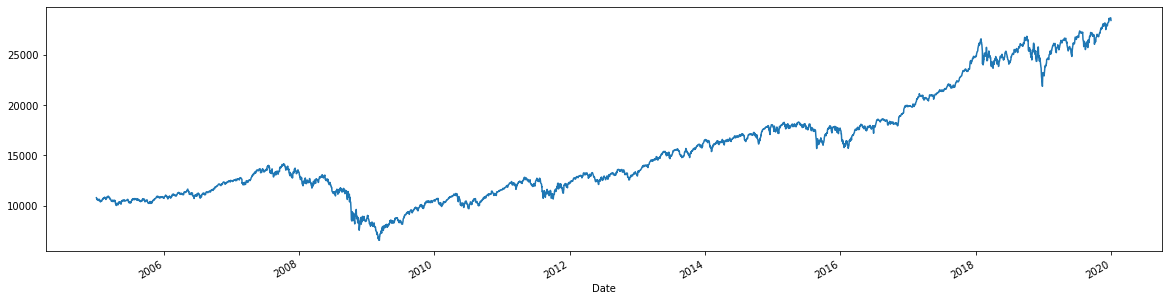

In [219]:
open_values.plot(figsize=(20,5))

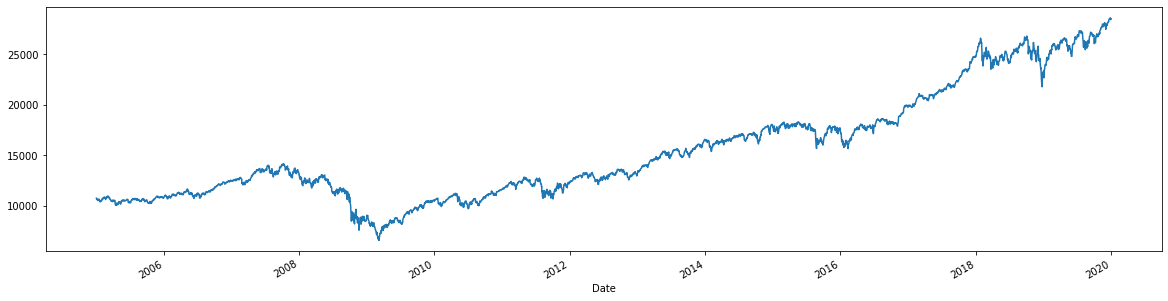

In [220]:
close_values.plot(figsize=(20,5))

Visti in questo modo, è difficile notare differenze tra il grafico dei valori di apertura e quello dei valori di chiusura. Per questo motivo nel seguente grafico vengono messi a confronto i valori di apertura e di chiusura in un intervallo di date ristretto
- I valori considerati vanno dal `2019-12-01` al `2020-01-01`

In [0]:
last_month_open_values = open_values["2019-12-01":"2020-01-01"]
last_month_close_values = close_values["2019-12-01":"2020-01-01"]

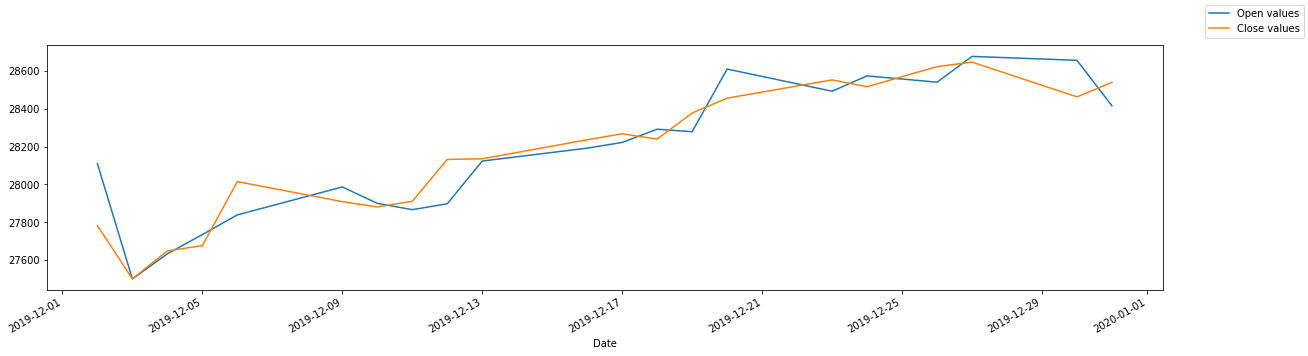

In [222]:
figure = plt.figure(figsize=(20, 5))
last_month_open_values.plot(label="Open values")
last_month_close_values.plot(label="Close values")
figure.legend()

Posso notare che il valore di apertura di una giornata, non corrisponde al valore di chiusura del giorno precedente

Infine, visualizziamo il rapporto che c'è tra il valore di apertura e chiusura dello stesso giorno, tramite un grafico di dispersione
- I valori sono relativi all'intervallo di date considerato precedentemente

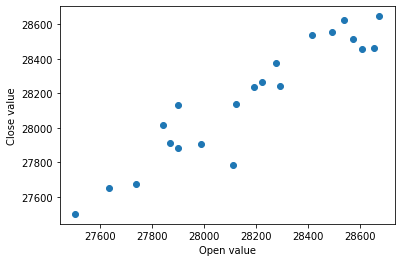

In [223]:
plt.scatter(last_month_open_values, last_month_close_values)
plt.xlabel("Open value")
plt.ylabel("Close value")
plt.show()

##ALGORITMO DI DAY TRADING

Il nostro algoritmo per effettuare Day Traiding, ripreso dalla lezione di laboratorio relativa agli indici di borsa, funziona nel seguente modo:

- Dato che ad inizio giornata sappiamo il valore di apertura dell'indice, tramite il nostro modello prevederemo quello di chiusura della giornata stessa 

  - Se il nostro modello ha previsto un rialzo per la chiusura dell'indice, allora acquisteremo un titolo, per poi rivenderlo a fine giornata

  - Se il nostro modello ha previsto un ribasso per la chiusura dell'indice, venderemo il titolo, per poi riacquistarlo a fine giornata

Per migliorare l'efficienza della nostra predizione, definiamo `delta_values`, che corrisponderà alla differenza tra il valore di chiusura e il valore di apertura di una giornata. I valori di `delta_values` saranno reali e predetti.

In [0]:
delta_values = close_values - open_values

###Features

Oltre a `delta_values`, `high_values` e `low_values`, andiamo a considerare altre features. Queste features che andiamo a considerare sono legate ai valori di High, Low e Close.   
Le features sono
- `close_oscillation_values`, ovvero un valore che più è vicino a zero e più significa che i valori che l'indice ha assunto durante la giornata non si discostano molto dal valore di chiusura della giornata stessa
- `open_oscillation_values`, ovvero un valore che più è vicino a zero e più significa che i valori che l'indice ha assunto durante la giornata non si discostano molto dal valore di apertura della giornata stessa


In [0]:
high_close_delta_values = high_values.shift(1) - close_values.shift(1)
close_low_delta_values = close_values.shift(1) - low_values.shift(1)
high_open_delta_values = high_values.shift(1) - open_values.shift(1)
open_low_delta_values = open_values.shift(1) - low_values.shift(1)

In [0]:
close_oscillation_values = abs(high_close_delta_values.shift(1) - close_low_delta_values.shift(1))
open_oscillation_values = abs(high_open_delta_values.shift(1) - open_low_delta_values.shift(1))

Questi due valori ci possono dare un idea di quanto il valore dell'indice sia stabile durante il corso di una giornata. Questo perchè se entrambi i valori sono molto bassi, significa che il valore dell'indice non ha avuto grandi oscillazioni





Visualizziamo dei grafici relativi alle features enunciate precedentemente

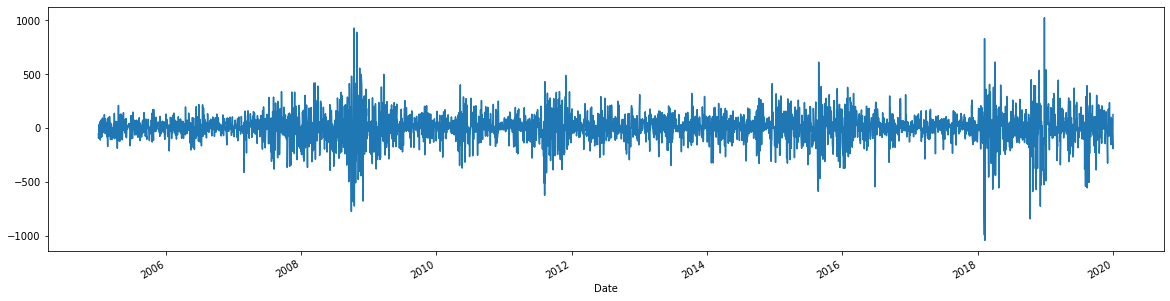

In [227]:
delta_values.plot(figsize=(20,5))

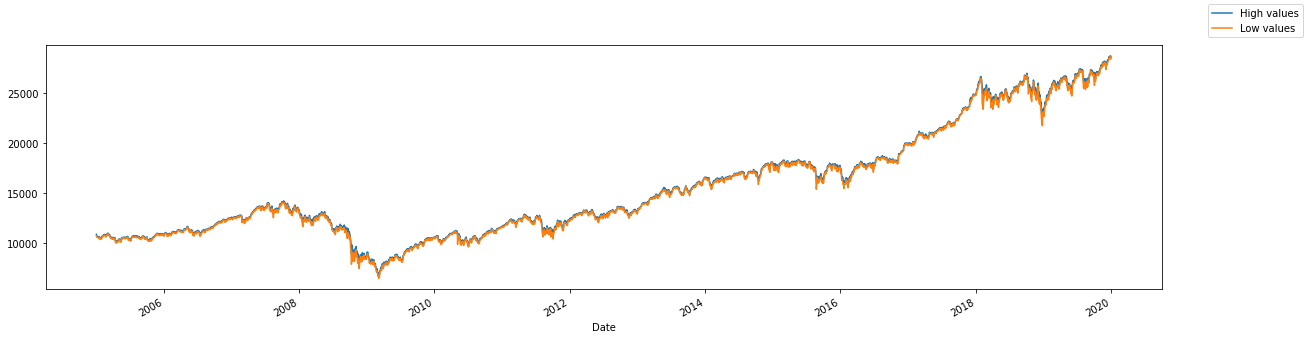

In [228]:
figure = plt.figure(figsize=(20, 5))
high_values.plot(label="High values")
low_values.plot(label="Low values")
figure.legend()

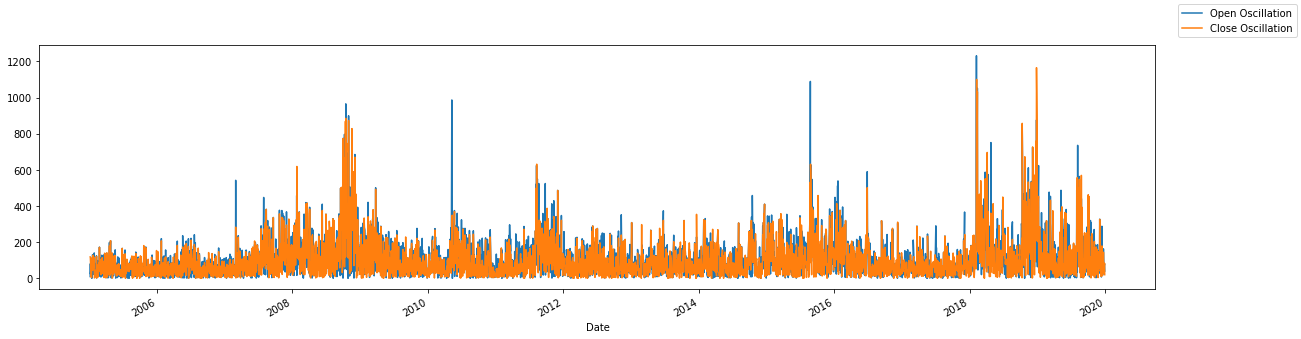

In [229]:
figure = plt.figure(figsize=(20, 5))
open_oscillation_values.plot(label="Open Oscillation")
close_oscillation_values.plot(label="Close Oscillation")
figure.legend()

Studiamo la correlazione tra `delta_values` e  `open_oscillation_values`. Vogliamo vedere se a valori basi di uno, corrispondo valori bassi dell'altro   
- Considereremo i valori assoluti dei valori di `delta_values`

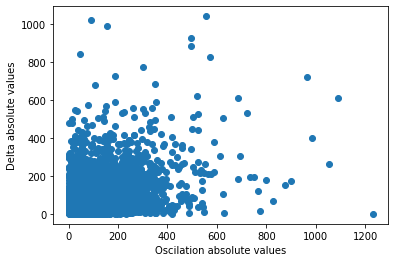

In [230]:
plt.scatter(open_oscillation_values, abs(delta_values))
plt.xlabel("Oscilation absolute values")
plt.ylabel("Delta absolute values")
plt.show()

Vedendo il grafico, si può notare un'alta densità di punti nell'angolo sinistro in basso. Da ciò possiamo dedurre che esiste una correlazione tra le feature considerate

Possiamo effettuare un discroso analogo per quanto riguarda lo studio della correlazione tra `delta_values` e `open_oscillation_values`

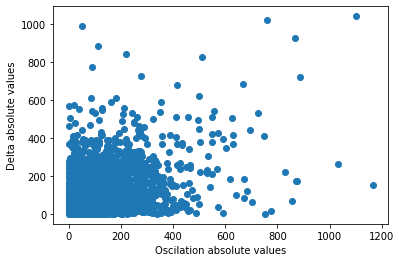

In [231]:
plt.scatter(close_oscillation_values, abs(delta_values))
plt.xlabel("Oscilation absolute values")
plt.ylabel("Delta absolute values")
plt.show()

Per studiare al meglio la correlazione tra le features, ora consideriamo i valori corrispondenti ad un periodo di due mesi, che va dal `2019-11-01` al `2020-01-01`.  
Mostriamo la correlazione tramite un grafico
- Nell'analizzare il grafico bisogna ricordarsi che `open_oscillation_values` e `close_oscillation_values` si riferiscono al giorno precedente

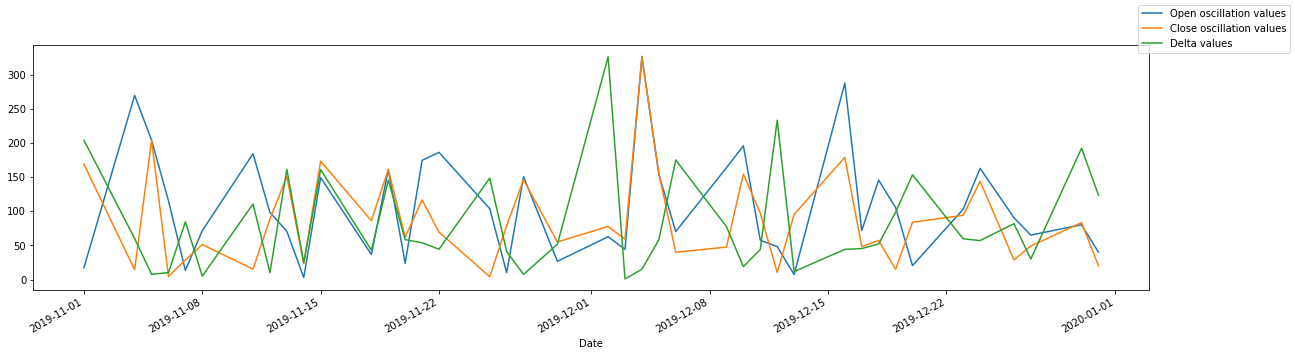

In [232]:
figure = plt.figure(figsize=(20, 5))
open_oscillation_values["2019-11-01":"2020-01-01"].plot(label="Open oscillation values")
close_oscillation_values["2019-11-01":"2020-01-01"].plot(label="Close oscillation values")
abs(delta_values["2019-11-01":"2020-01-01"]).plot(label="Delta values")
figure.legend()

### Funzioni


Definiamo la funzione `gain`. Tale funzione, prende in input i valori reali e predetti di `delta_values`, e ci restituisce il guadagno di un investitore
- `growth` e `decline` sono due serie booleane che indicano, rispettivamente, in quali giorni è previsto un rialzo del valore e in quali un ribasso

In [0]:
def gain(D, D_pred):
    growth = D_pred > 0
    decline = D_pred < 0
    return D[growth].sum() - D[decline].sum()

Definiamo una nuova metrica `roi`, che riusa il guadagno `gain` definito sopra e lo rapporta all'investimento medio. **ROI**, Return on Investment, è un indice che ci esprime quanto il nostro capitale, investito in DJIA, ci stia rendendo

In [0]:
def roi(D, D_pred):
    mean_open = open_values.reindex_like(D).mean()
    return gain(D, D_pred) / mean_open

Definiamo la funzione `prepare_data`, la quale, prendendo in input un dizionario di variabili predittive `features` e una variabile da predire `target`, crea e resistuisce
- Il frame `X` con le variabili predittive e privo delle righe con valori mancanti
- La serie `y` con i valori della variabile da predire corrispondenti alle righe selezionate di `X`

Utilizziamo il metodo `dropna` per eliminare tutte le righe con uno o più valori mancanti, che si sono venute a formare con il metodo `shift`, utilizzato per generare variabili che si riferiscono ai dati dei giorni precedenti
- `inplace=True` indica di modificare X invece di restituire un frame nuovo

In [0]:
def prepare_data(features, target):
    X = pd.DataFrame(features)
    X.dropna(inplace=True)
    y = target.reindex_like(X)
    return X, y

Definiamo la funzione `print_eval`, la quale, prendendo in input il frame con le variabili predittive, la serie con i valori della variabile da predire e il modello, stampa le metriche di valutazione del modello

In [0]:
def print_eval(X, y, model):
    preds = model.predict(X)
    print("Gain: {:.2f}$".format(gain(y, preds)))
    print(" ROI: {:.3%}".format(roi(y, preds)))

###Suddivisione dei dati

- Suddividiamo i dati in **training** e **validation** set   
- Avendo una serie temporale, è comune utilizzare come training i dati fino ad una data specifica e come validation quelli successivi. Per questo motivo definiamo la funzione `split_before_2015` che, dati X e y, restituisca in una tupla con 4 elementi    
  - Un training set X_train e y_train con i dati fino al 2015   
  - Un validation set X_val e y_val con i dati dal 2015 in poi
- La scelta dell'anno 2015 è dovuta al fatto che è l'anno centrale del periodo di dieci anni che stiamo considerando

In [0]:
def split_before_2015(X, y):
    is_train = X.index.year < 2015
    X_train = X.loc[is_train]
    y_train = y.loc[is_train]
    X_val = X.loc[~is_train]
    y_val = y.loc[~is_train]
    return X_train, X_val, y_train, y_val

###Features più rilevanti

Creiamo un dizionario `features`

In [0]:
features = {}
for i in range(1, 4):
  features["DeltaLag{}".format(i)] = delta_values.shift(i)
for i in range(1, 4):
  features["HighLag{}".format(i)] = high_values.shift(i)
for i in range(1, 4):
  features["LowLag{}".format(i)] = low_values.shift(i)
for i in range(1, 4):
  features["OpenOscillationLag{}".format(i)] = open_oscillation_values.shift(i)
for i in range(1, 4):
  features["CloseOscillationLag{}".format(i)] = close_oscillation_values.shift(i)

In [239]:
X, y = prepare_data(features, delta_values)
X.head()

DeltaLag1  DeltaLag2  ...  CloseOscillationLag2  CloseOscillationLag3
Date                              ...                                            
2005-01-10     -20.84      29.69  ...                113.15                118.60
2005-01-11      17.59     -20.84  ...                 86.52                113.15
2005-01-12     -63.55      17.59  ...                 11.15                 86.52
2005-01-13      56.46     -63.55  ...                 17.07                 11.15
2005-01-14    -111.58      56.46  ...                  4.06                 17.07

[5 rows x 15 columns]

In [240]:
X.tail()

DeltaLag1  DeltaLag2  ...  CloseOscillationLag2  CloseOscillationLag3
Date                              ...                                            
2019-12-24      59.75    -153.55  ...                 83.97                 14.87
2019-12-26     -57.12      59.75  ...                 94.20                 83.97
2019-12-27      81.93     -57.12  ...                144.06                 94.20
2019-12-30     -30.08      81.93  ...                 28.79                144.06
2019-12-31    -192.62     -30.08  ...                 49.11                 28.79

[5 rows x 15 columns]

Per individuare le feature più rilevanti usiamo il metodo di regressione **LASSO**, Least Absolute Shrinkage and Selection Operator
- imposto $α=3$. Il parametro $α$ controlla il peso della regolarizzazione 

In [241]:
model = Lasso(alpha=3)
model.fit(X, y)
pd.Series(model.coef_, X.columns)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35811623.72607408, tolerance: 7359.663215005266
  positive)


DeltaLag1              -0.055453
DeltaLag2              -0.041772
DeltaLag3               0.032418
HighLag1               -0.009615
HighLag2               -0.005965
HighLag3                0.000736
LowLag1                 0.007310
LowLag2                -0.001041
LowLag3                 0.008307
OpenOscillationLag1    -0.075536
OpenOscillationLag2    -0.039161
OpenOscillationLag3     0.008744
CloseOscillationLag1    0.134241
CloseOscillationLag2    0.010839
CloseOscillationLag3   -0.004192
dtype: float64

Sulla base di questa analisi, selezioniamo le features per il training dei modelli.  
Scarteremo le features `high_values` e `low_values`

In [0]:
features = {}
for i in range(1, 4):
  features["DeltaLag{}".format(i)] = delta_values.shift(i)
for i in range(1, 4):
  features["OpenOscillationLag{}".format(i)] = open_oscillation_values.shift(i)
for i in range(1, 4):
  features["CloseOscillationLag{}".format(i)] = close_oscillation_values.shift(i)

In [243]:
X, y = prepare_data(features, delta_values)
X.head()

DeltaLag1  DeltaLag2  ...  CloseOscillationLag2  CloseOscillationLag3
Date                              ...                                            
2005-01-10     -20.84      29.69  ...                113.15                118.60
2005-01-11      17.59     -20.84  ...                 86.52                113.15
2005-01-12     -63.55      17.59  ...                 11.15                 86.52
2005-01-13      56.46     -63.55  ...                 17.07                 11.15
2005-01-14    -111.58      56.46  ...                  4.06                 17.07

[5 rows x 9 columns]

##MODELLI

Andiamo a generare diversi modelli di learning applicabili al nostro caso di studio

In [0]:
X_train, X_val, y_train, y_val = split_before_2015(X, y)

Incapsuliamo la metrica `roi` in un oggetto scorer con la funzione `make_scorer`. Nel nostro caso settiamo `greater_is_better` a`True` in quanto stiamo cercando i modelli migliori

In [0]:
roi_scorer = make_scorer(roi, greater_is_better=True)


Creiamo una funzione per la gestione e visualizzazione dei risultati della GridSearch
- Usiamo GreadSearch per la ricerca degli iperparametri migliori   
La funzione `create_gs_and_display_results` crea il modello grid search specificando tutti i parametri, lo addestra e poi ne ritorna il risultato

In [0]:
def create_gs_and_display_results(model, grid):
  gs = GridSearchCV(model, grid, scoring=roi_scorer, cv=tss)
  gs.fit(X, y);
  gs_results = pd.DataFrame(gs.cv_results_)
  return gs_results.sort_values("mean_test_score", ascending=False)

###Modello Casuale

Come primo modello consideriamo un modello casuale. L'obiettivo di questo modello è quello di dimostrare cosa succederebbe se si prendessero delle decisioni casuali.


In [0]:
rois = []
for s in range(1000):
    np.random.seed(s)
    preds = np.random.normal(y_train.mean(), y_train.std(), len(y_val))
    rois.append(roi(y_val, preds))

Visualizziamo il ROI medio calcolato su 1.000 test con predizioni casuali

In [248]:
np.mean(rois)

0.0064815544356854335

Possiamo notare che il valore del ROI medio è estramamente piccolo, circa `0.97%`. Ciò significa che i modelli casuali non sono affidabili

###K-Fold per serie temporali

In [0]:
tss = TimeSeriesSplit(3)

In [250]:
for i, (train, val) in enumerate(tss.split(X), start=1):
    print("FOLD {}".format(i))
    train_dates = X.index[train]
    val_dates = X.index[val]
    print("Training set da {} a {}".format(train_dates.min(), train_dates.max()))
    print("Validation set da {} a {}".format(val_dates.min(), val_dates.max()))

FOLD 1
Training set da 2005-01-10 00:00:00 a 2008-10-08 00:00:00
Validation set da 2008-10-09 00:00:00 a 2012-07-05 00:00:00
FOLD 2
Training set da 2005-01-10 00:00:00 a 2012-07-05 00:00:00
Validation set da 2012-07-06 00:00:00 a 2016-04-05 00:00:00
FOLD 3
Training set da 2005-01-10 00:00:00 a 2016-04-05 00:00:00
Validation set da 2016-04-06 00:00:00 a 2019-12-31 00:00:00


In [0]:
cv_results = cross_validate(LinearRegression(), X, y, scoring=roi_scorer, cv=tss)


In [252]:
cv_results["test_score"]

array([0.68182582, 0.25758704, 0.11347135])

In [253]:
cv_results["test_score"].mean()

0.35096140383070296

###Regressione ridge


In [0]:
ridge_regression = Pipeline([
    ("scale",  StandardScaler()),
    ("regression", Ridge())
])

Definiamo la griglia

In [0]:
ridge_regression_grid = {
    "regression__alpha": [0.1, 1, 10, 50]
}

Creiamo il modello grid search specificando tutti i parametri, lo addestriamo e poi ne analizziamo i risultati ottenuti

In [256]:
ridge_regression_result = create_gs_and_display_results(ridge_regression, ridge_regression_grid)
ridge_regression_result

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0       0.008851      0.003781  ...        0.241241                1
1       0.005359      0.000299  ...        0.241241                1
2       0.004971      0.000220  ...        0.227703                3
3       0.005012      0.000280  ...        0.214504                4

[4 rows x 12 columns]

###Regressione Polinomiale

 Regressione polinomiale con o senza standardizzazione delle feature generate

In [0]:
poly_regression = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scale", None),
    ("regr", LinearRegression())
])


Definiamo la griglia. Consideriamo i gradi del polinomio che vanno da 1 a 10

In [0]:
poly_regression_grid = {
    "scale": [None, StandardScaler()],
    "poly__degree": list(range(1, 5))
}

Il caso 1 corrisponde alla regressione lineare standard 

Creiamo il modello grid search specificando tutti i parametri, lo addestriamo e poi ne analizziamo i risultati ottenuti

In [259]:
poly_regression_result = create_gs_and_display_results(poly_regression, poly_regression_grid)
poly_regression_result.head()

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0       0.004955      0.000051  ...        0.241241                1
1       0.005965      0.000437  ...        0.241241                1
2       0.011983      0.002781  ...        0.135204                3
3       0.014611      0.004143  ...        0.135204                3
4       0.049700      0.014057  ...        0.095061                5

[5 rows x 13 columns]

Possiamo notare come le migliori configurazioni, indipendentemente dalla standardizzazione, sono quelle con le feature di 3° grado

###Regressione kernel ridge


Per la regressione kernel ridge, usiamo come kernel `rbf`, radial-basis function

In [0]:
kernel_ridge_regression = Pipeline([
    ("scale", None),
    ("regr", KernelRidge(kernel="rbf"))
])

Definiamo la griglia

In [0]:
kernel_ridge_regression_grid = {
    "scale": [None, StandardScaler()],
    "regr__gamma": [0.0001, 0.001, 0.01, 1],
    "regr__alpha": np.logspace(-3, 2, 6)
}

Creiamo il modello grid search specificando tutti i parametri, lo addestriamo e poi ne analizziamo i risultati ottenuti

In [262]:
kernel_ridge_regression_result = create_gs_and_display_results(kernel_ridge_regression, kernel_ridge_regression_grid)
kernel_ridge_regression_result.head()

mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
19       0.395304      0.297855  ...        0.268827                1
1        0.395200      0.300850  ...        0.328975                2
21       0.391794      0.296135  ...        0.245578                3
11       0.392606      0.297673  ...        0.115591                4
27       0.394852      0.299397  ...        0.100333                5

[5 rows x 14 columns]

##SELEZIONE MODELLI MIGLIORI

Andremo a selezionare un modello per ognuna delle tipologie di regressioni analizzate.  
Nella scelta dei modelli andremo a considerare i valori che assumo in `mean_test_score` e `std_test_score`

In [0]:
scores ={}


Per quanto riguarda la **regressione ridge**, il modello migliore è quello con
- `regression__alpha = 0.1`
- Il suo score è `mean_test_score = 0.350961`
- La sua deviazione standard `std_test_score = 0.241241`

In [0]:
scores["ridge"] = 0.350961

Per quanto riguarda la **regressione polinomiale**, il modello migliore è quello con
- La standardizzazione è indefferente
- Grado del polinomio `poly__degree = 1`
- Il suo score è `mean_test_score = 0.350961`
- La sua deviazione standard `std_test_score = 0.241241`

In [0]:
scores["poly"] = 0.350961

Per quanto riguarda la **regressione kernel ridge**, selezioniamo due modelli.
- Il primo:
  - Standardizzata
  - Gamma `regr__gamma = 0.001`
  - Alpha `regr__alpha = 0.1`
  - Il suo score è `mean_test_score = 0.443158`
  - La sua deviazione standard `std_test_score = 0.268827`

- Il secondo: 
  - Standardizzata
  - Gamma `regr__gamma = 0.001`
  - Alpha `regr__alpha = 0.01`
  - Il suo score è `mean_test_score = 0.390901`
  - La sua deviazione standard `std_test_score = 0.115591`

In [0]:
scores["kernel_ridge_1"] = 0.443158
scores["kernel_ridge_2"] = 0.390901

In [267]:
scores

{'kernel_ridge_1': 0.443158,
 'kernel_ridge_2': 0.390901,
 'poly': 0.350961,
 'ridge': 0.350961}

Calcoliamo gli intervalli di confidenza predittivi fissata la confidenza del **95%**

In [0]:
def difference_between_two_models(error1, error2, confidence):
    z_half_alfa = stats.norm.ppf(confidence)
    variance = (((1 - error1) * error1) / len(y_val)) + (((1 - error2) * error2) / len(y_val))
    d_minus = abs(error1 - error2) - z_half_alfa * (pow(variance, 0.5))
    d_plus = abs(error1 - error2) + z_half_alfa * (pow(variance, 0.5))
    print("Valore minimo: {}\nValore massimo: {}\n".format(d_minus, d_plus))

In [0]:
ridge_error = 1 - scores["ridge"]
poly_error = 1- scores["poly"]
kernel_ridge_1_error = 1 - scores["kernel_ridge_1"]
kernel_ridge_2_error = 1 - scores["kernel_ridge_2"]

In [270]:
print("Regressione ridge vs regressione polinomiale, intervallo di confidenza:")
difference_between_two_models(ridge_error, poly_error, 0.95)

print("Regressione ridge vs regressione kernel ridge (1), intervallo di confidenza:")
difference_between_two_models(ridge_error, kernel_ridge_1_error, 0.95)

print("Regressione ridge vs regressione kernel ridge (2), intervallo di confidenza:")
difference_between_two_models(ridge_error, kernel_ridge_2_error, 0.95)

print("Regressione polinomiale vs regressione kernel ridge (1), intervallo di confidenza:")
difference_between_two_models(poly_error, kernel_ridge_1_error, 0.95)

print("Regressione polinomiale vs regressione kernel ridge (2), intervallo di confidenza:")
difference_between_two_models(poly_error, kernel_ridge_2_error, 0.95)

print("Regressione kernel ridge (1) vs regressione kernel ridge (2), intervallo di confidenza:")
difference_between_two_models(kernel_ridge_1_error, kernel_ridge_2_error, 0.95)

Regressione ridge vs regressione polinomiale, intervallo di confidenza:
Valore minimo: -0.03130161607794617
Valore massimo: 0.03130161607794617

Regressione ridge vs regressione kernel ridge (1), intervallo di confidenza:
Valore minimo: 0.060249944448166906
Valore massimo: 0.12414405555183282

Regressione ridge vs regressione kernel ridge (2), intervallo di confidenza:
Valore minimo: 0.008286174798622647
Valore massimo: 0.07159382520137708

Regressione polinomiale vs regressione kernel ridge (1), intervallo di confidenza:
Valore minimo: 0.060249944448166906
Valore massimo: 0.12414405555183282

Regressione polinomiale vs regressione kernel ridge (2), intervallo di confidenza:
Valore minimo: 0.008286174798622647
Valore massimo: 0.07159382520137708

Regressione kernel ridge (1) vs regressione kernel ridge (2), intervallo di confidenza:
Valore minimo: 0.019964774322290726
Valore massimo: 0.08454922567770927



Possiamo notare che gli score del modello della regressione ridge e di quello della regressione polinomiale hanno stessi risultati.  
Visto che siamo interessati ad avere un alto score e al contempo una bassa deviazione(più il valore della deviazione è alto e più rischiamo che, cambiando i dati, le predizioni non siano accurate), possiamo escluderli visto che non hanno ne lo score migliore tra quelli dei modelli selezionati, ne una bassa deviazione.   

##MODELLO MIGLIORE

La scelta del modello migliore ricade tra i due modelli della **regressione kernel ridge**.   
La nostra scelta ricade nel secondo. Questo perchè il secondo, a discapito di una differenza di circa 5 punti percentuali rispetto allo score del primo, ha una deviazione nettamente più bassa (differenza di circa 15 punti percentuali tra i due).  


In [0]:
result_model = Pipeline([("scale", StandardScaler()),("regr", KernelRidge(kernel="rbf", alpha=0.01, gamma=0.001))])

Per finire analizziamo i parametri appresi (coefficienti degli iperpiani)

In [0]:
result_model.fit(X, y)
coef = pd.Series(np.dot(X.transpose(), result_model["regr"].dual_coef_), X.columns)

Li stampiamo

In [273]:
coef

DeltaLag1              -2.361054e+06
DeltaLag2              -3.939134e+06
DeltaLag3               6.162549e+06
OpenOscillationLag1    -5.271330e+04
OpenOscillationLag2    -9.810236e+05
OpenOscillationLag3     5.619819e+06
CloseOscillationLag1    2.953698e+06
CloseOscillationLag2   -1.122998e+06
CloseOscillationLag3    6.787712e+06
dtype: float64

Ricordiamo che la variabile che vogliamo predire è `delta_values`


Possiamo notare che non c'è una maggioranza di parametri positivi o negativi, tuttavia se stringiamo il cerchio ai parametri che si riferiscono fino a 2 giorni precedenti, si hanno praticamente solo valori negativi.   
Ciò indica che questi parametri sono inversamente proporzionali alla variabile da predire.